In [23]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt 

#### Задание 1

Задача линейного программирования:
$$
\begin{array}{ll}
\mbox{минимизировать } &~ c^Tx\\
\mbox{при условии } 
&~x\geq 0\\
&~ Ax=b 
\end{array}
$$
Лагранжиан:
$$
L(x, \lambda, \mu)=c^Tx-\lambda^Tx+\mu^T(Ax-b)
$$
Двойственная функция:
$$
q(\lambda, \mu)=
\begin{cases}
-\infty, & c-\lambda+A^T\mu\neq 0 \\
-\mu^Tb, &c-\lambda+A^T\mu=0
\end{cases}
$$
Двойственная задача:
$$
\begin{array}{ll}
\mbox{максимизировать } &~ -\mu^Tb\\
\mbox{при условии } &~ c-\lambda+A^T\mu=0 \\
&~\lambda\geq 0
\end{array}
$$

In [2]:
def solve_dual(A, b, c):
    """
    A: np.ndarray (m, n)
    b: np.ndarray (m)
    c: np.ndarray (n)
    """
    m, n = A.shape
    mu = cp.Variable(m)
    l = cp.Variable(n)
    objective = cp.Minimize(mu @ b)
    constraints = [c.T - l.T + mu.T @ A== 0, l >= 0]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return l.value, mu.value

Для минимума $f$ верно:
$$
q(\lambda^*, \mu^*)= f(x^*) \\
-\mu^Tb = c^Tx 
$$

$c-\lambda+A^T\mu=0 \Rightarrow \forall x\ \  c^Tx-\lambda^Tx+\mu^T A x=0 $, то есть нам достаточно найти такой $x$, для которого верно $\lambda^T x = 0$ (и т.ч. $Ax= b$).

In [3]:
def solve_primal(A, b, c):
    """
    A: np.ndarray (m, n)
    b: np.ndarray (m)
    c: np.ndarray (n)
    """
    m, n = A.shape
    l, mu = solve_dual(A, b, c)
    x = np.zeros(n)
    mask = np.isclose(l, 0)
    x[mask] = np.linalg.inv(A[:, mask]) @ b
    return x

#### Задание 2

По сути решаем задачу:
$$
\begin{array}{ll}
\mbox{минимизировать } &~ r\\
\mbox{при условии } 
&~r\geq 0\\
&~ x_i^Tx_i - 2x_i^Tx + x^Tx \leq r, \ i = 1, \dots, m
\end{array}
$$

In [4]:
def smallest_bounding_sphere(X):
    """
    X: np.ndarray (m, n)
    X = [x_1, ... x_m]
    """
    m, n = X.shape
    r2 = cp.Variable(1)
    x = cp.Variable(n)
    objective = cp.Minimize(r2)
    constraints = [X[i] @ X[i] - 2 * X[i] @ x + cp.sum(x ** 2) <= r2 for i in range(m)] + [r2 >= 0]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return x.value, np.sqrt(r2.value)

In [13]:
x, r = smallest_bounding_sphere(np.array([[0, 0], [3, 1], [2, 4]]))
assert abs(np.linalg.norm(x - [1, 2])) < 1e-4 and abs(r - np.sqrt(5)) < 1e-4

#### Задача 3


Решаем задачу:
$$
\begin{array}{ll}
\mbox{максимизировать } &~ \min\limits_{y_i = 1} a^Tx_i - \max\limits_{y_i = 0} a^Tx_i\\
\mbox{при условии } 
&~||a||^2 = 1 \\
\end{array}
$$
А это то же самое, что решать задачу:
$$
\begin{array}{ll}
\mbox{максимизировать } &~ p1 - p0\\
\mbox{при условии } 
&~||a||^2 = 1\\
&~p1 \leq  \min\limits_{y_i = 1} a^Tx_i \\
&~p0 \geq \max\limits_{y_i = 0} a^Tx_i
\end{array}
$$


In [30]:
def svm(X, Y):
    """
    Y: np.ndarray (m)
    X: np.ndarray (m, n)
    X = [x_1, ... x_m]
    """
    m, n = X.shape
    a = cp.Variable(n)
    p1 = cp.Variable(1)
    p0 = cp.Variable(1)
    objective = cp.Maximize(p1 - p0)
    constraints = [p1 <= x @ a for x in X[Y == 1]] + [p0 >= x @ a for x in X[Y == 0]] + [cp.sum(a ** 2) <= 1]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return a.value

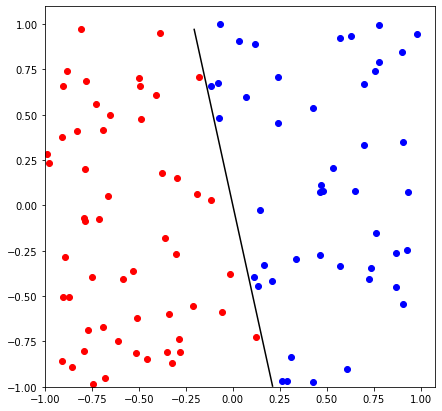

In [52]:
fig, ax = plt.subplots(figsize=[7, 7])
n = 2
m = 100
X = 2 * np.random.rand(m, n) - 1
a = np.random.rand(n)

Y = (np.sign(X @ a) + 1) / 2
# линейно неразделимые классы
#Y = (np.sign(X @ a + (np.random.random(m) - 0.5) / 2) + 1) / 2

ax.scatter(X[Y == 0, 0], X[Y == 0, 1], color='red')
ax.scatter(X[Y == 1, 0], X[Y == 1, 1], color='blue')

a_svm = svm(X, Y)

#Level contours
delta = 0.025
x_ = np.arange(-1, 1, delta)
y_ = np.arange(-1, 1, delta)
X, Y = np.meshgrid(x_, y_)
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i][j] = a_svm @ np.array([X[i][j], Y[i][j]])
        
CS = ax.contour(X, Y, Z, [0], colors=['black'])
plt.close(fig)
fig